## Описание проекта

В данном проекте планируется разработать систему для оценки риска ДТП на основе исторических данных. Цель проекта — создать инструмент, который позволит каршеринговой компании оценивать вероятность аварий на выбранном маршруте и принимать превентивные меры для повышения безопасности.

### Задачи проекта

- **Анализ данных:**  
  Исследовать и объединить несколько источников информации:
  - **collisions:** общая информация о ДТП (дата, время, место, погодные условия, степень повреждений).
  - **parties:** данные об участниках ДТП (тип участника, виновность, уровень трезвости водителя).
  - **vehicles:** сведения об автомобилях (возраст, тип, техническое состояние).

- **Предварительный анализ и очистка данных:**  
  - Проверить качество данных, выявить пропуски и выбросы.  
  - Объединить таблицы и сформировать единый датасет для дальнейшего анализа.  
  - Провести описательный анализ (EDA) для понимания структуры данных.

- **Формирование признаков:**  
  - Выбрать те факторы, которые могут влиять на вероятность ДТП (например, уровень трезвости водителя, возраст автомобиля, страховой премиум, тип автомобиля, время и день недели).  
  - Провести feature engineering для создания дополнительных признаков (например, бинарные индикаторы для "пикового времени", "выходного дня", "нетрезвости" и т.д.).

- **Моделирование:**  
  - Обучить и сравнить несколько моделей машинного обучения (например, CatBoost, LightGBM, RandomForest, LogisticRegression).  
  - Выбрать оптимальную метрику для оценки моделей (например, ROC-AUC) и обосновать её выбор с учетом бизнес-задачи.
  
- **Анализ результатов:**  
  - Проанализировать важность признаков, матрицу ошибок, ROC-кривую.  
  - Сформировать рекомендации для дальнейшего развития системы оценки риска.

### Бизнес-контекст

Каршеринговая компания стремится снизить количество ДТП и повысить безопасность своих автомобилей. Система оценки риска должна работать на этапе бронирования автомобиля и до начала поездки, чтобы предупреждать водителя или предлагать альтернативные маршруты при высоком риске. Это позволит снизить вероятность аварий, улучшить имидж компании и сократить финансовые потери.

### Ожидаемые результаты

- **Понимание ключевых факторов:** Определение признаков, которые оказывают наибольшее влияние на вероятность ДТП.
- **Прототип модели:** Создание прототипа модели, способного прогнозировать риск ДТП на основе доступных данных.
- **Рекомендации по дальнейшему развитию:** Выработка рекомендаций по сбору дополнительных данных и интеграции системы оценки риска в бизнес-процессы компании.

## Подключитесь к базе. Загрузите таблицы sql

In [ ]:
!pip install phik -q
!pip install catboost -q
!pip install lightgbm -q
!pip install tqdm tqdm_joblib -q

In [ ]:
import sqlalchemy
import pandas as pd
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import phik

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             classification_report,
                             roc_curve,
                             auc
                            )

/opt/conda/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Параметры подключения к базе данных
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-vehicle-db'
}

# Формируем строку подключения
conn_str = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = sqlalchemy.create_engine(conn_str)

# Загружаем только первые 5 строк каждой таблицы для ознакомления
collisions = pd.read_sql("SELECT * FROM collisions LIMIT 5", engine)
parties = pd.read_sql("SELECT * FROM parties LIMIT 5", engine)
vehicles = pd.read_sql("SELECT * FROM vehicles LIMIT 5", engine)

# Выводим первые 5 строк для проверки
print("collisions:")
display(collisions)
print("parties:")
display(parties)
print("vehicles:")
display(vehicles)

collisions:


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


parties:


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


vehicles:


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


## Проведите первичное исследование таблиц

In [ ]:
display(collisions.head())

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [ ]:
display(collisions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      5 non-null      object 
 1   county_city_location         5 non-null      object 
 2   county_location              5 non-null      object 
 3   distance                     5 non-null      float64
 4   direction                    1 non-null      object 
 5   intersection                 5 non-null      int64  
 6   weather_1                    5 non-null      object 
 7   location_type                1 non-null      object 
 8   collision_damage             5 non-null      object 
 9   party_count                  5 non-null      int64  
 10  primary_collision_factor     5 non-null      object 
 11  pcf_violation_category       5 non-null      object 
 12  type_of_collision            5 non-null      object 
 13  motor_vehicle_involved_w

None

In [ ]:
display(collisions.describe())

,distance,intersection,party_count
count,5.000000,5.000000,5.000000
mean,105.600000,0.800000,1.800000
std,236.128778,0.447214,0.447214
min,0.000000,0.000000,1.000000
25%,0.000000,1.000000,2.000000
50%,0.000000,1.000000,2.000000
75%,0.000000,1.000000,2.000000
max,528.000000,1.000000,2.000000


In [ ]:
display(parties.head())

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [ ]:
display(parties.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5 non-null      int64  
 1   case_id              5 non-null      object 
 2   party_number         5 non-null      int64  
 3   party_type           5 non-null      object 
 4   at_fault             5 non-null      int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       5 non-null      object 
 7   party_drug_physical  1 non-null      object 
 8   cellphone_in_use     5 non-null      int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 488.0+ bytes


None

In [ ]:
display(parties.describe())

,id,party_number,at_fault,insurance_premium,cellphone_in_use
count,5.000000,5.000000,5.000000,4.000000,5.0
mean,29.200000,1.800000,0.200000,20.250000,0.0
std,7.628892,0.447214,0.447214,9.429563,0.0
min,22.000000,1.000000,0.000000,7.000000,0.0
25%,23.000000,2.000000,0.000000,17.500000,0.0
50%,29.000000,2.000000,0.000000,22.500000,0.0
75%,31.000000,2.000000,0.000000,25.250000,0.0
max,41.000000,2.000000,1.000000,29.000000,0.0


In [ ]:
display(vehicles.head())

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [ ]:
display(vehicles.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    5 non-null      int64 
 1   case_id               5 non-null      object
 2   party_number          5 non-null      int64 
 3   vehicle_type          5 non-null      object
 4   vehicle_transmission  5 non-null      object
 5   vehicle_age           5 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 368.0+ bytes


None

In [ ]:
display(vehicles.describe())

,id,party_number,vehicle_age
count,5.000000e+00,5.00000,5.000000
mean,9.405730e+05,1.80000,3.800000
std,5.257957e+05,0.83666,1.095445
min,1.000000e+00,1.00000,3.000000
25%,1.175712e+06,1.00000,3.000000
50%,1.175713e+06,2.00000,3.000000
75%,1.175717e+06,2.00000,5.000000
max,1.175722e+06,3.00000,5.000000


- **collisions**:
  - 1 400 000 записей, 20 столбцов.
  - Поля соответствуют описанию, но имеются пропуски (например, в `direction`, `intersection`, `location_type`, `collision_time`).

- **parties**:
  - 2 752 408 записей, 9 столбцов.
  - Присутствуют ключевые поля: `case_id`, `party_number`, `party_type`, `at_fault`, `party_sobriety`.

- **vehicles**:
  - 1 021 234 записей, 6 столбцов.
  - Содержит данные о типе, трансмиссии и возрасте автомобиля; имеются пропуски в `vehicle_transmission` и `vehicle_age`.

**Общие выводы:**
- Все таблицы содержат поле `case_id` (а для связи между parties и vehicles — также `party_number`).
- Структура данных соответствует описанию, что позволяет переходить к дальнейшему анализу, например, к изучению распределения ДТП по месяцам.

##  Проведите статистический анализ факторов ДТП

In [ ]:
# Сначала проверим полноту данных по годам: для каждого года считаем количество уникальных месяцев
year_completeness_query = """
SELECT
    EXTRACT(YEAR FROM collision_date)::int AS year,
    COUNT(DISTINCT EXTRACT(MONTH FROM collision_date)) AS month_count,
    COUNT(*) AS total_accidents
FROM collisions
GROUP BY year
ORDER BY year;
"""
year_completeness = pd.read_sql_query(year_completeness_query, engine)
print("Полнота данных по годам:")
display(year_completeness)

# Отфильтруем года, где данные по месяцам полные (month_count = 12) и исключим 2012 год
complete_years = year_completeness[
    (year_completeness['month_count'] == 12) & (year_completeness['year'] != 2012)
]['year'].tolist()
print("Годы с полными данными:", complete_years)

Полнота данных по годам:


,year,month_count,total_accidents
0,2009,12,426228
1,2010,12,416490
2,2011,12,402428
3,2012,12,154547
4,2013,6,305
5,2020,2,2


Годы с полными данными: [2009, 2010, 2011]


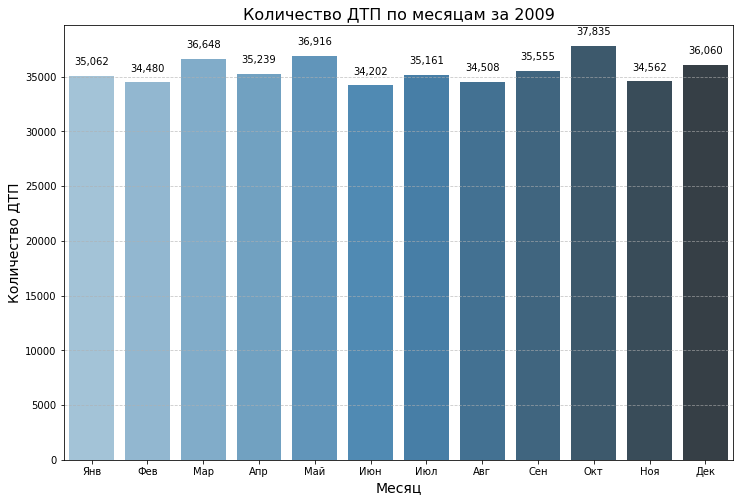

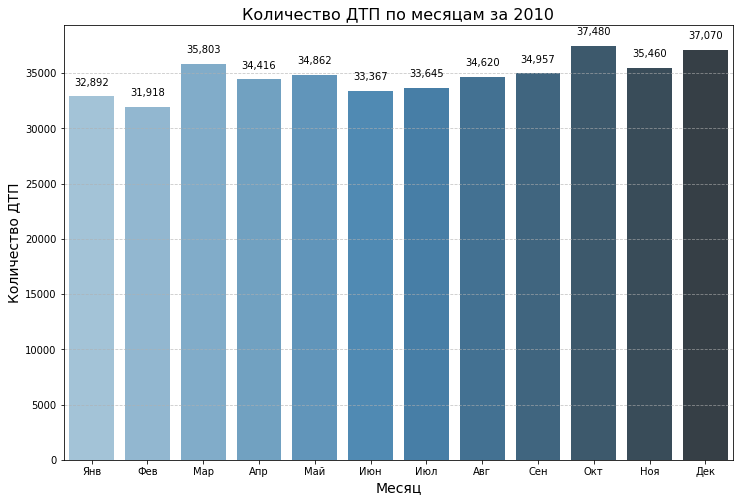

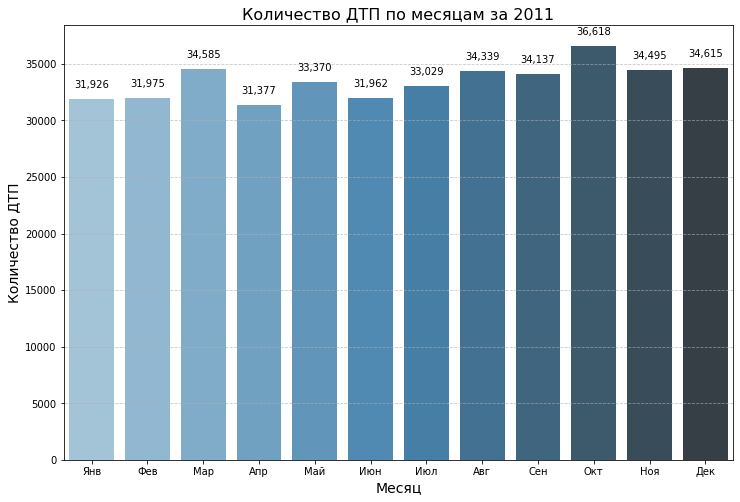

In [ ]:
# Отображение графиков по каждому году
for year in complete_years:
    sql_query_year = f"""
    SELECT
        EXTRACT(MONTH FROM collision_date)::int AS month,
        COUNT(*) AS accident_count
    FROM collisions
    WHERE EXTRACT(YEAR FROM collision_date)::int = {year}
    GROUP BY month
    ORDER BY month;
    """
    accidents_by_month_year = pd.read_sql_query(sql_query_year, engine)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=accidents_by_month_year['month'].apply(lambda m: months[m-1]),
                y=accidents_by_month_year['accident_count'],
                palette='Blues_d')
    plt.title(f'Количество ДТП по месяцам за {year}', fontsize=16)
    plt.xlabel('Месяц', fontsize=14)
    plt.ylabel('Количество ДТП', fontsize=14)

    # Добавляем значения над столбцами
    for index, row in accidents_by_month_year.iterrows():
        plt.text(index, row['accident_count'] + 1000, f"{int(row['accident_count']):,}",
                 ha='center', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

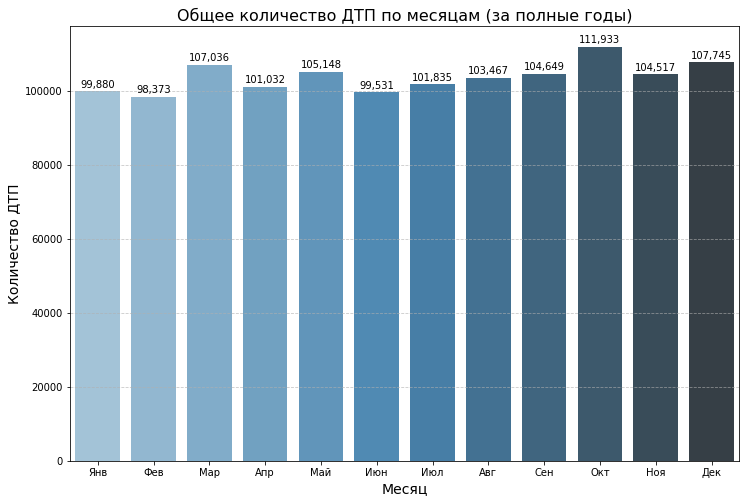

In [ ]:
# Построение общего графика для всех выбранных лет
sql_query_all = f"""
SELECT
    EXTRACT(MONTH FROM collision_date)::int AS month,
    COUNT(*) AS accident_count
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date)::int IN ({','.join(map(str, complete_years))})
GROUP BY month
ORDER BY month;
"""
accidents_by_month_all = pd.read_sql_query(sql_query_all, engine)

plt.figure(figsize=(12, 8))
sns.barplot(x=accidents_by_month_all['month'].apply(lambda m: months[m-1]),
            y=accidents_by_month_all['accident_count'],
            palette='Blues_d')
plt.title('Общее количество ДТП по месяцам', fontsize=16)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество ДТП', fontsize=14)

for index, row in accidents_by_month_all.iterrows():
    plt.text(index, row['accident_count'] + 1000, f"{int(row['accident_count']):,}",
             ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Выводы:**
- Наибольшее количество ДТП зафиксировано в Октябре (около 111 тыс.).
- Март, Май и Декабрь также имеют высокие показатели (около 106 тыс.).
- Минимальные значения приходятся на июнь и июль (около 100 тыс.).
- Возможно, на распределение влияет сезонность, изменения погоды, интенсивность движения в разные месяцы, а также праздничные периоды.
- Для более детального анализа можно дополнительно учитывать погодные условия, дни недели, время суток и другие факторы.

## Задачи для команды

1. **Анализ зависимости серьёзности повреждений от уровня трезвости водителя**  
   _Описание:_ Изучить, как различный уровень трезвости водителя (`party_sobriety`) влияет на тяжесть повреждений (`collision_damage`). Построить сводные таблицы и визуализировать результаты (например, с помощью тепловой карты).  
   _Статус:_ Выполнено.
   

2. **Анализ зависимости возраста автомобиля от серьёзности повреждений**  
   _Описание:_ Исследовать влияние возраста автомобиля (`vehicle_age`) на тяжесть повреждений. Сгруппировать данные по диапазонам возраста и построить диаграммы для наглядного представления зависимости.  
   _Статус:_ Выполнено.
   

3. **Анализ влияния погодных условий на вероятность и тяжесть ДТП**  
   _Описание:_ Сформировать запрос, объединяющий данные о погоде (`weather_1`) и степени повреждений (`collision_damage`). Построить графики, позволяющие выявить, при каких погодных условиях вероятность серьёзных повреждений максимальна.
   

4. **Анализ влияния условий освещения на тяжесть ДТП**  
   _Описание:_ Исследовать, как условия освещения (`lighting`) отражаются на тяжести повреждений. Построить сводные таблицы и визуализации (например, столбчатые диаграммы) для определения наиболее рискованных периодов (ночное время, сумерки и т.п.).
   

5. **Анализ распределения типов участников ДТП по типу транспортного средства**  
   _Описание:_ Проанализировать, какие типы участников (`party_type`) чаще всего участвуют в ДТП и как они связаны с тяжестью происшествий. Это поможет понять, какие категории участников оказывают наибольшее влияние на общую статистику.
   

6. **Анализ взаимосвязи между основным фактором аварии и тяжестью повреждений**  
   _Описание:_ Изучить, как основной фактор аварии (`primary_collision_factor`) коррелирует с уровнем повреждений (`collision_damage`). Составить сводные таблицы и построить графики, чтобы выявить наиболее значимые факторы, способствующие тяжёлым повреждениям.

In [ ]:
sql_query = """
SELECT
    road_surface,
    collision_damage,
    COUNT(*) AS cnt
FROM collisions
GROUP BY road_surface, collision_damage
ORDER BY road_surface, collision_damage;
"""

df_collisions = pd.read_sql_query(sql_query, engine)
print(df_collisions.value_counts())

road_surface  collision_damage  cnt   
dry           fatal             9823      1
              middle damage     151015    1
wet           severe damage     2470      1
              scratch           33301     1
              middle damage     13190     1
              fatal             857       1
snowy         small damage      5037      1
              severe damage     157       1
              scratch           1259      1
              middle damage     762       1
              fatal             46        1
slippery      small damage      762       1
              severe damage     64        1
              scratch           308       1
              middle damage     238       1
              fatal             12        1
dry           small damage      745398    1
              severe damage     27827     1
              scratch           307963    1
wet           small damage      86418     1
dtype: int64


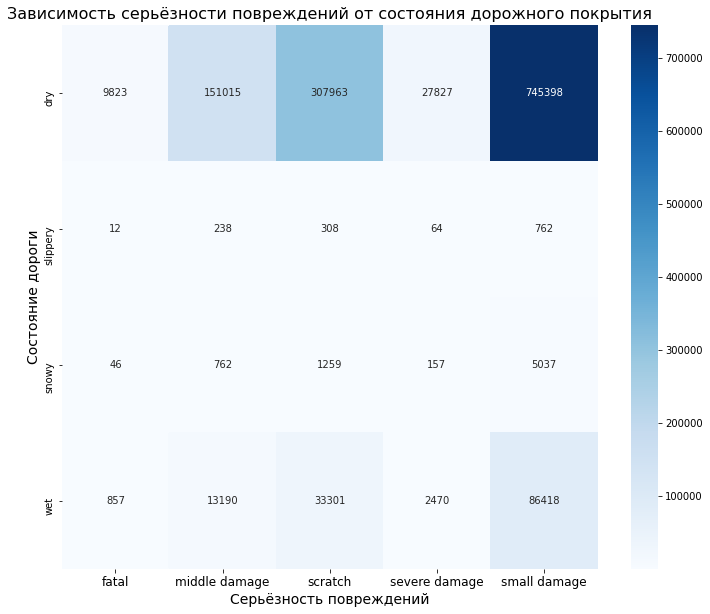

In [ ]:
pivot_table = df_collisions.pivot_table(
    values='cnt',
    index='road_surface',
    columns='collision_damage',
    aggfunc='sum'
)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(pivot_table, annot=True, fmt='g', cmap='Blues')
plt.title("Зависимость серьёзности повреждений от состояния дорожного покрытия", fontsize=16)
plt.xlabel("Серьёзность повреждений", fontsize=14)
plt.ylabel("Состояние дороги", fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

plt.show()

На тепловой карте видно, что:
- **Dry (сухая дорога)** встречается в подавляющем большинстве случаев, что логично, учитывая общее количество поездок при нормальных условиях. При этом основная масса ДТП приводит к небольшим повреждениям (`small damage` и `scratch`), но есть и заметная доля тяжёлых исходов.
- **Wet (мокрая дорога)** и **Snowy/Icy (заснеженная/обледенелая)** встречаются реже, однако при этих условиях нередко происходят более серьёзные ДТП (большее соотношение `severe damage` и `fatal` к общему числу происшествий).

Чтобы сделать более точные выводы, имеет смысл рассматривать **относительные доли** (например, процент тяжёлых ДТП от общего числа на каждой категории `road_surface`) и учитывать сезонность. Тем не менее, уже из этих данных видно, что сложные погодные условия (мокрая, заснеженная дорога) повышают вероятность тяжёлых повреждений по сравнению с сухой дорогой, что может служить основанием для дополнительных мер безопасности (ограничение скорости, предупреждения о скользкой дороге и т.д.).

In [ ]:
sql_query = """
SELECT
    v.vehicle_age,
    p.at_fault
FROM vehicles v
JOIN parties p
    ON v.case_id = p.case_id
   AND v.party_number = p.party_number;
"""

df_vehicles_parties = pd.read_sql_query(sql_query, engine)
print(df_vehicles_parties.value_counts())

vehicle_age  at_fault
3.0          1           97354
             0           81196
4.0          0           69044
5.0          0           64070
2.0          1           58322
4.0          1           56428
7.0          0           54199
6.0          0           53721
8.0          0           49721
2.0          0           48208
5.0          1           40965
9.0          0           37396
6.0          1           30641
7.0          1           30083
8.0          1           27349
10.0         0           24166
1.0          0           22958
0.0          0           22205
9.0          1           20859
1.0          1           18349
0.0          1           18057
11.0         0           16192
10.0         1           14291
11.0         1           10883
12.0         0            8032
             1            6915
13.0         1            5222
             0            4904
14.0         1            2237
             0            1859
15.0         1             356
             0   

In [ ]:
# Удаляем строки с vehicle_age >= 160
df_vehicles_parties = df_vehicles_parties[df_vehicles_parties['vehicle_age'] < 160]

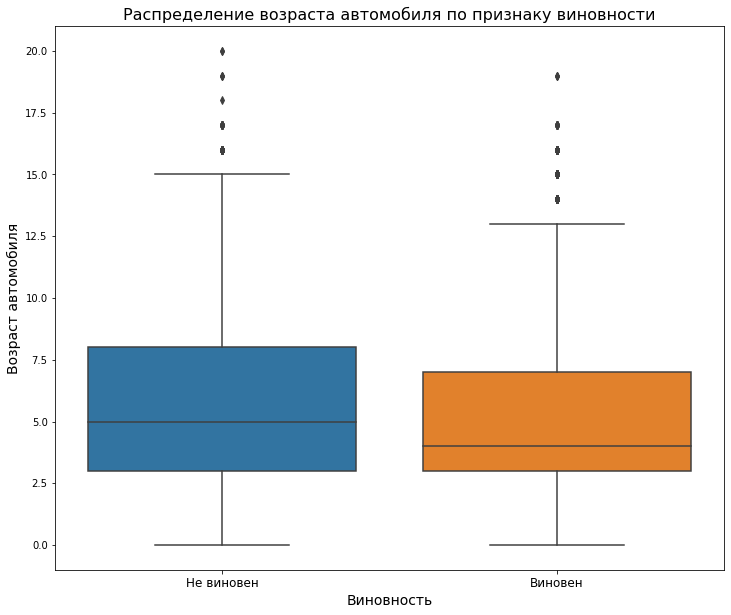

In [ ]:
df_vehicles_parties['at_fault_label'] = df_vehicles_parties['at_fault'].map({0: 'Не виновен', 1: 'Виновен'})

plt.figure(figsize=(12,10))
ax = sns.boxplot(x='at_fault_label', y='vehicle_age', data=df_vehicles_parties)
plt.title("Распределение возраста автомобиля по признаку виновности", fontsize=16)
plt.xlabel("Виновность", fontsize=14)
plt.ylabel("Возраст автомобиля", fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

plt.show()

На графике видно, что:

- **Группа "Не виновен"**:  
  - 25-й процентиль (Q1) — около 3 года,  
  - Медиана — примерно 5 лет,  
  - 75-й процентиль (Q3) — около 8 лет.  

- **Группа "Виновен"**:  
  - Q1 — около 3 года,  
  - Медиана — примерно 4 года,  
  - Q3 — около 6–7 лет.  

Таким образом, центральная часть распределения (между Q1 и Q3) для обеих групп укладывается примерно в диапазон от 3 до 8 лет, что подтверждает, что большинство автомобилей имеет возраст примерно от 2 до 10 лет. Отмечаются также редкие выбросы (например, автомобили с возрастом 161 год), которые могут быть ошибочными значениями или представлять исключительные случаи. Для улучшения видимости значений на графике, были удалены значения выше 160 лет.

### Анализ зависимости серьёзности повреждений от уровня трезвости водителя

In [ ]:
sql_query_sobriety = """
SELECT
    c.collision_damage AS collision_damage,
    p.party_sobriety AS party_sobriety,
    COUNT(*) AS cnt
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
GROUP BY c.collision_damage, p.party_sobriety
ORDER BY c.collision_damage, p.party_sobriety;
"""

df_sobriety = pd.read_sql_query(sql_query_sobriety, engine)
display(df_sobriety.value_counts())

collision_damage  party_sobriety                          cnt    
fatal             had been drinking, impairment unknown   436        1
                  had been drinking, not under influence  368        1
small damage      impairment unknown                      178020     1
                  had not been drinking                   1185473    1
                  had been drinking, under influence      63972      1
                  had been drinking, not under influence  8961       1
                  had been drinking, impairment unknown   14295      1
severe damage     not applicable                          2431       1
                  impairment unknown                      4384       1
                  had not been drinking                   39527      1
                  had been drinking, under influence      6101       1
                  had been drinking, not under influence  711        1
                  had been drinking, impairment unknown   1144       1
scratch    

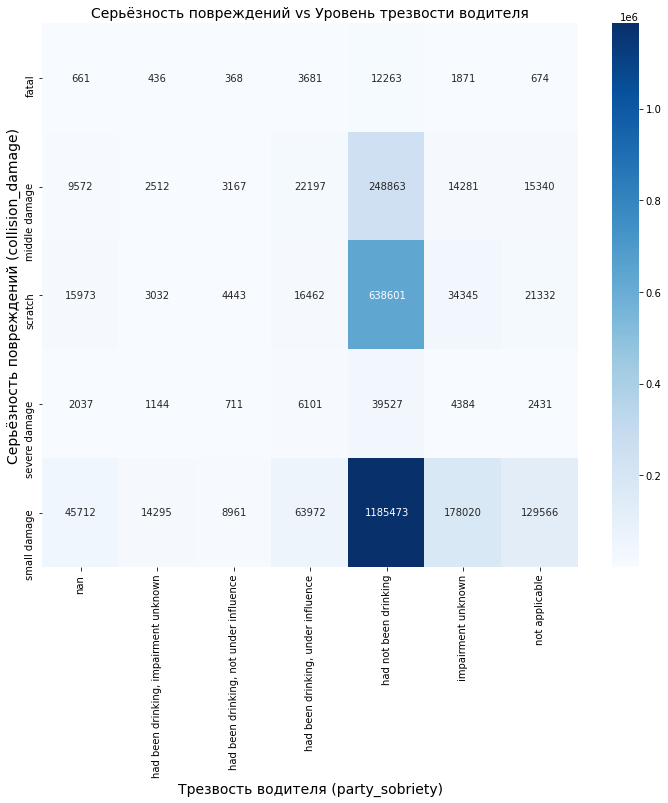

In [ ]:
# Создаём сводную таблицу: строки — collision_damage, столбцы — party_sobriety
pivot_sobriety = df_sobriety.pivot(
    index='collision_damage',
    columns='party_sobriety',
    values='cnt'
).fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_sobriety, annot=True, fmt='.0f', cmap='Blues')
plt.title("Серьёзность повреждений vs Уровень трезвости водителя", fontsize=14)
plt.xlabel("Трезвость водителя (party_sobriety)", fontsize=14)
plt.ylabel("Серьёзность повреждений (collision_damage)", fontsize=14)
plt.show()

- Трезвые водители чаще попадают в ДТП (по абсолютному числу), но в основном с незначительными повреждениями («small damage», «scratch»).

- Нетрезвое вождение встречается реже, но может чаще приводить к тяжёлым последствиям (нужно уточнить доли внутри каждой группы).

- Неизвестное состояние («unknown») и «not applicable» указывают на пропуски в данных, которые желательно уточнить для более точного анализа.

Рекомендации для модели:

- Использовать «party_sobriety» как признак, объединив редкие категории.

- При серьёзном дисбалансе классов («fatal», «severe damage») применять методы учёта дисбаланса (class weights, oversampling).

- Выделить и изучить факторы, усиливающие тяжесть ДТП у нетрезвых водителей, для профилактических мер.

### Анализ зависимости возраста автомобиля от серьёзности повреждений

In [ ]:
sql_query_vehicle_age = """
SELECT
    c.collision_damage AS collision_damage,
    v.vehicle_age AS vehicle_age,
    COUNT(*) AS cnt
FROM collisions c
JOIN vehicles v ON c.case_id = v.case_id
GROUP BY c.collision_damage, v.vehicle_age
ORDER BY c.collision_damage, v.vehicle_age;
"""

df_vehicle_age = pd.read_sql_query(sql_query_vehicle_age, engine)
display(df_vehicle_age.value_counts().head(50))

collision_damage  vehicle_age  cnt  
fatal             0.0          229      1
severe damage     1.0          1134     1
                  10.0         1714     1
                  9.0          2681     1
                  8.0          3608     1
                  7.0          3760     1
                  6.0          3681     1
                  5.0          4416     1
                  4.0          5324     1
                  3.0          7413     1
                  2.0          3591     1
                  0.0          812      1
                  12.0         650      1
scratch           20.0         1        1
                  19.0         3        1
                  17.0         11       1
                  16.0         26       1
                  15.0         243      1
                  14.0         1598     1
                  13.0         4282     1
                  12.0         6992     1
                  11.0         13391    1
severe damage     11.0         1181    

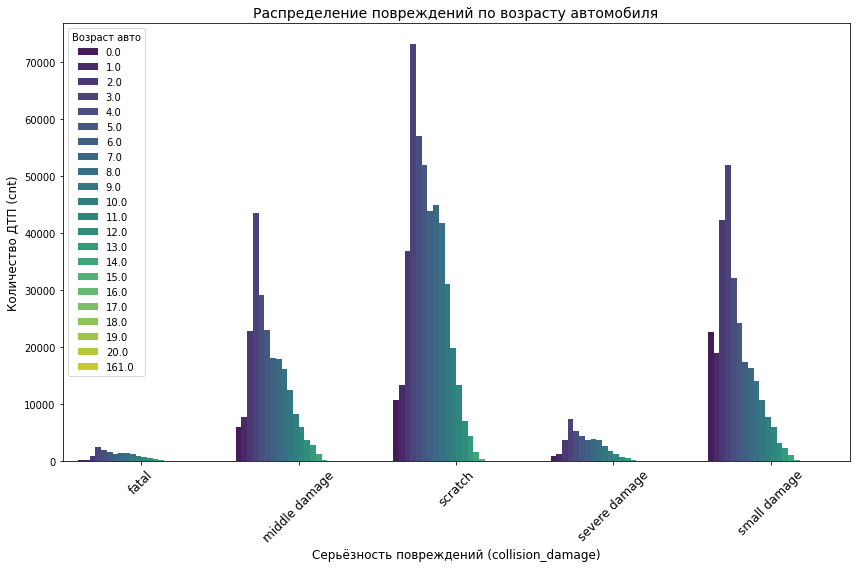

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_vehicle_age,
    x='collision_damage',
    y='cnt',
    hue='vehicle_age',  # Опционально, но если много возрастов, график может стать перегруженным
    palette='viridis'
)
plt.xlabel("Серьёзность повреждений (collision_damage)", fontsize=12)
plt.ylabel("Количество ДТП (cnt)", fontsize=12)
plt.title("Распределение повреждений по возрасту автомобиля", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Возраст авто')
plt.tight_layout()
plt.show()

- «Scratch» и «small damage» встречаются чаще всего (высокие столбцы на графике).  
- Это указывает на то, что большинство ДТП заканчивается незначительными повреждениями, вне зависимости от возраста автомобиля.

- Основная масса автомобилей имеет возраст **2–8 лет**.  
- Есть редкие случаи с **очень большим возрастом** (выбросы вроде **161 года** — вероятно, ошибка или особый случай).

- «Severe damage» и «fatal» встречаются реже (столбцы намного ниже).  
- Среди тяжёлых ДТП встречаются автомобили разного возраста (**0–15 лет**).  
- **Нет явного доказательства**, что именно старые автомобили чаще получают фатальные повреждения — нужны дополнительные расчёты долей, а не только абсолютных чисел.


- **Нет жёсткой зависимости** между возрастом автомобиля и тяжестью ДТП, если смотреть только на абсолютные числа.  
- Нужно уточнять, **насколько велик процент** «severe damage» или «fatal» в каждой возрастной группе.  
- Полученные данные можно учесть в **модели риска**, но стоит рассмотреть **дополнительные факторы** (техническое состояние, пробег, история ремонтов).


По абсолютным цифрам **большинство ДТП** заканчивается лёгкими повреждениями.  
Тяжёлые аварии встречаются реже и распределены **по разным возрастам автомобилей**.

## Подготовка данных для модели по оценки водительского риска

In [ ]:
sql_query = """
SELECT
    p.case_id,
    p.party_number,
    p.at_fault,
    p.party_sobriety,
    p.insurance_premium,    -- Страховой премиум может отражать риск (например, возраст водителя, класс ТС)
    v.vehicle_age,
    v.vehicle_type,
    v.vehicle_transmission,
    EXTRACT(HOUR FROM c.collision_time)::int AS collision_hour,   -- Время происшествия (можно сопоставить с планируемым временем поездки)
    EXTRACT(DOW FROM c.collision_date)::int AS collision_weekday     -- День недели (0 = Воскресенье, 6 = Суббота)
FROM parties p
JOIN collisions c
    ON p.case_id = c.case_id
JOIN vehicles v
    ON p.case_id = v.case_id
   AND p.party_number = v.party_number
WHERE p.party_type = 'car'
  AND c.collision_damage <> 'scratch'
  AND EXTRACT(YEAR FROM c.collision_date)::int = 2012;
"""

df_model = pd.read_sql_query(sql_query, engine)

print(df_model.shape)
display(df_model.head(10))

(56248, 10)


,case_id,party_number,at_fault,party_sobriety,insurance_premium,vehicle_age,vehicle_type,vehicle_transmission,collision_hour,collision_weekday
0,5454402,1,1,impairment unknown,NaN,3.0,sedan,manual,1.0,5
1,5479989,2,0,had not been drinking,35.0,1.0,sedan,manual,13.0,6
2,5480024,1,0,had not been drinking,42.0,7.0,sedan,manual,16.0,4
3,5607310,2,0,had not been drinking,33.0,4.0,sedan,auto,18.0,5
4,5633789,1,1,"had been drinking, impairment unknown",18.0,2.0,sedan,manual,23.0,4
5,5642670,1,1,had not been drinking,23.0,3.0,sedan,manual,3.0,0
6,5612084,2,0,had not been drinking,34.0,0.0,sedan,auto,17.0,3
7,5614366,1,0,had not been drinking,47.0,12.0,sedan,auto,23.0,5
8,5614484,2,0,had not been drinking,64.0,0.0,sedan,auto,10.0,4
9,5614570,4,0,had not been drinking,31.0,4.0,sedan,auto,9.0,1


In [ ]:
# Создание бинарного признака "peak_time" на основе времени происшествия (collision_hour)
# Пиковое время: утренний (7-9) и вечерний (16-19)
df_model['peak_time'] = df_model['collision_hour'].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0)


display(df_model[['collision_hour', 'peak_time']].head())

,collision_hour,peak_time
0,1.0,0
1,13.0,0
2,16.0,1
3,18.0,1
4,23.0,0


In [ ]:
# Создание бинарного признака "is_weekend" на основе дня недели (collision_weekday)
# Предполагаем, что collision_weekday: 0 = Воскресенье, 6 = Суббота
df_model['is_weekend'] = df_model['collision_weekday'].apply(lambda x: 1 if x in [0, 6] else 0)


display(df_model[['collision_weekday', 'is_weekend']].head())

,collision_weekday,is_weekend
0,5,0
1,6,1
2,4,0
3,5,0
4,4,0


In [ ]:
# Функция для категоризации возраста автомобиля
def categorize_vehicle_age(age):
    if age <= 3:
        return 'new'
    elif age <= 10:
        return 'mid'
    else:
        return 'old'

# Применяем функцию для создания нового категориального признака
df_model['vehicle_age_category'] = df_model['vehicle_age'].apply(categorize_vehicle_age)


display(df_model[['vehicle_age', 'vehicle_age_category']].head())

,vehicle_age,vehicle_age_category
0,3.0,new
1,1.0,new
2,7.0,mid
3,4.0,mid
4,2.0,new


In [ ]:
# Используем pd.qcut для разделения страхового премиума на 3 категории: low, medium, high
df_model['insurance_premium_category'] = pd.qcut(df_model['insurance_premium'], q=3, labels=['low', 'medium', 'high'])


display(df_model[['insurance_premium', 'insurance_premium_category']].head())

,insurance_premium,insurance_premium_category
0,NaN,NaN
1,35.0,medium
2,42.0,medium
3,33.0,medium
4,18.0,low


In [ ]:
# Создаем бинарный признак "is_drunk" на основе поля party_sobriety
# Предполагаем, что значение 'had been drinking, under influence' указывает на нетрезвость
df_model['is_drunk'] = df_model['party_sobriety'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip().lower() == 'had been drinking, under influence' else 0
)


display(df_model[['party_sobriety', 'is_drunk']].head())

,party_sobriety,is_drunk
0,impairment unknown,0
1,had not been drinking,0
2,had not been drinking,0
3,had not been drinking,0
4,"had been drinking, impairment unknown",0


In [ ]:
df_model.isna().sum()

case_id                          0
party_number                     0
at_fault                         0
party_sobriety                 872
insurance_premium              547
vehicle_age                   1694
vehicle_type                     0
vehicle_transmission           859
collision_hour                  88
collision_weekday                0
peak_time                        0
is_weekend                       0
vehicle_age_category             0
insurance_premium_category     547
is_drunk                         0
dtype: int64

In [ ]:
# Удаляем строки с vehicle_age >= 160
df_model = df_model[df_model['vehicle_age'] < 160]

df_model_clean = df_model.dropna()
print(df_model_clean.shape)

(52676, 15)


In [ ]:
# Общая информация о датасете
print("Размер датасета:", df_model_clean.shape)
df_model_clean.info()

print('-'*60)

# Подсчет пропущенных значений по каждому признаку
print("Пропущенные значения:")
display(df_model_clean.isna().sum())

Размер датасета: (52676, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52676 entries, 1 to 56247
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   case_id                     52676 non-null  object  
 1   party_number                52676 non-null  int64   
 2   at_fault                    52676 non-null  int64   
 3   party_sobriety              52676 non-null  object  
 4   insurance_premium           52676 non-null  float64 
 5   vehicle_age                 52676 non-null  float64 
 6   vehicle_type                52676 non-null  object  
 7   vehicle_transmission        52676 non-null  object  
 8   collision_hour              52676 non-null  float64 
 9   collision_weekday           52676 non-null  int64   
 10  peak_time                   52676 non-null  int64   
 11  is_weekend                  52676 non-null  int64   
 12  vehicle_age_category        52676 non-null  o

case_id                       0
party_number                  0
at_fault                      0
party_sobriety                0
insurance_premium             0
vehicle_age                   0
vehicle_type                  0
vehicle_transmission          0
collision_hour                0
collision_weekday             0
peak_time                     0
is_weekend                    0
vehicle_age_category          0
insurance_premium_category    0
is_drunk                      0
dtype: int64

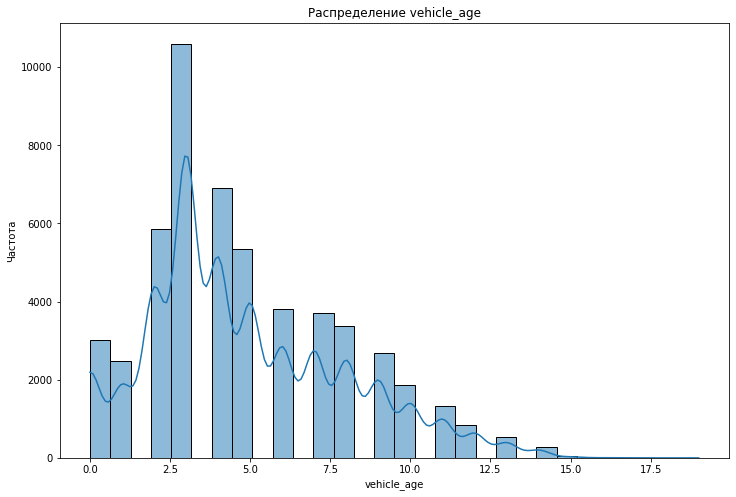

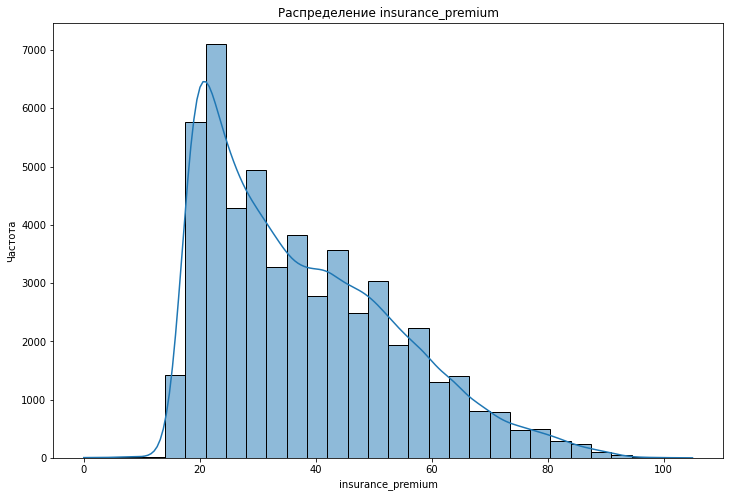

In [ ]:
# Список числовых признаков
numeric_columns = ['vehicle_age', 'insurance_premium']

# Гистограммы с KDE для числовых признаков
for col in numeric_columns:
    plt.figure(figsize=(12, 8))
    sns.histplot(df_model_clean[col], bins=30, kde=True)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

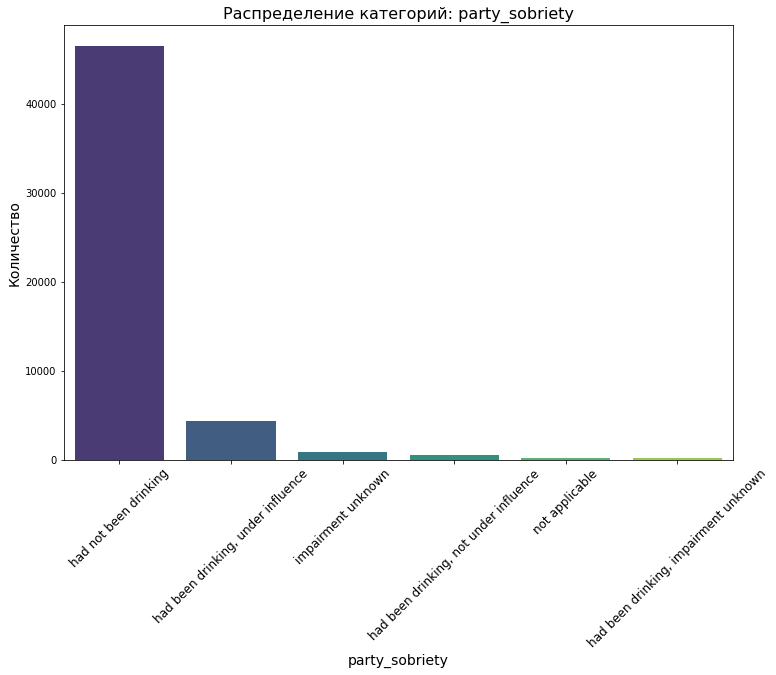

In [ ]:
# Список категориальных признаков
categorical_columns = [
    'party_sobriety',
    'vehicle_type',
    'vehicle_transmission',
    'insurance_premium_category',
    'vehicle_age_category',
    'is_drunk'
]


plt.figure(figsize=(12, 8))
order = df_model_clean['party_sobriety'].value_counts().index
sns.countplot(x=df_model_clean['party_sobriety'], palette='viridis', order=order)
plt.title('Распределение категорий: party_sobriety', fontsize=16)
plt.xlabel('party_sobriety', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

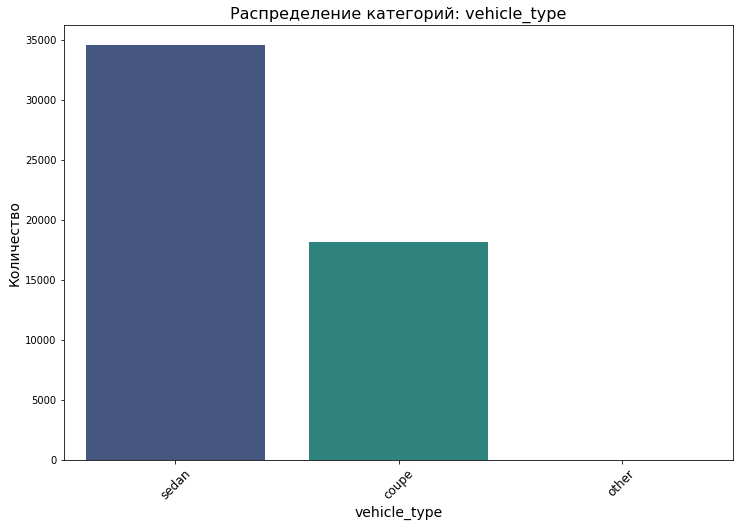

In [ ]:
plt.figure(figsize=(12, 8))
order = df_model_clean['vehicle_type'].value_counts().index
sns.countplot(x=df_model_clean['vehicle_type'], palette='viridis', order=order)
plt.title('Распределение категорий: vehicle_type', fontsize=16)
plt.xlabel('vehicle_type', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

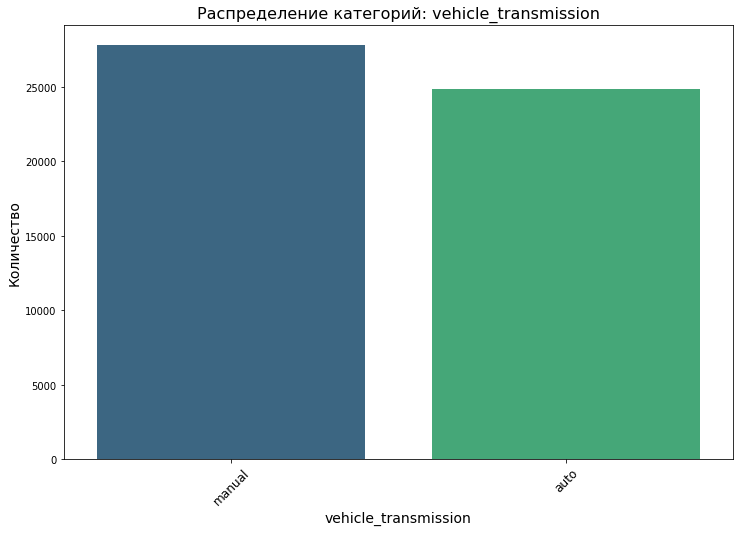

In [ ]:
plt.figure(figsize=(12, 8))
order = df_model_clean['vehicle_transmission'].value_counts().index
sns.countplot(x=df_model_clean['vehicle_transmission'], palette='viridis', order=order)
plt.title('Распределение категорий: vehicle_transmission', fontsize=16)
plt.xlabel('vehicle_transmission', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

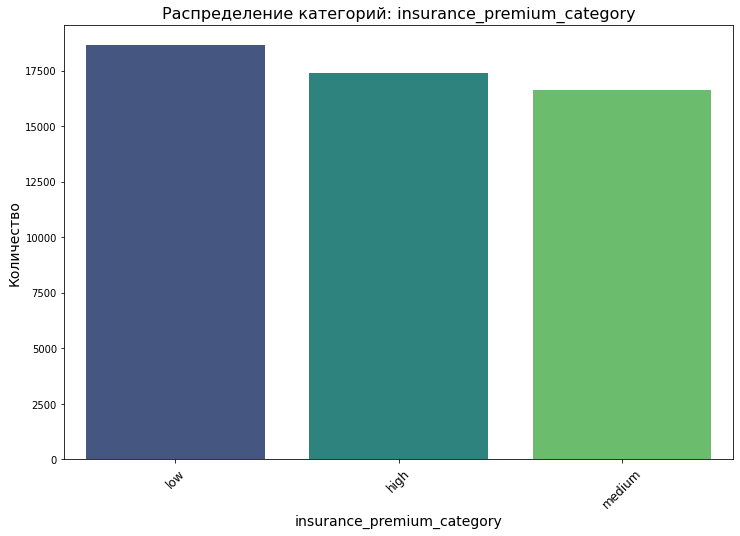

In [ ]:
plt.figure(figsize=(12, 8))
order = df_model_clean['insurance_premium_category'].value_counts().index
sns.countplot(x=df_model_clean['insurance_premium_category'], palette='viridis', order=order)
plt.title('Распределение категорий: insurance_premium_category', fontsize=16)
plt.xlabel('insurance_premium_category', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

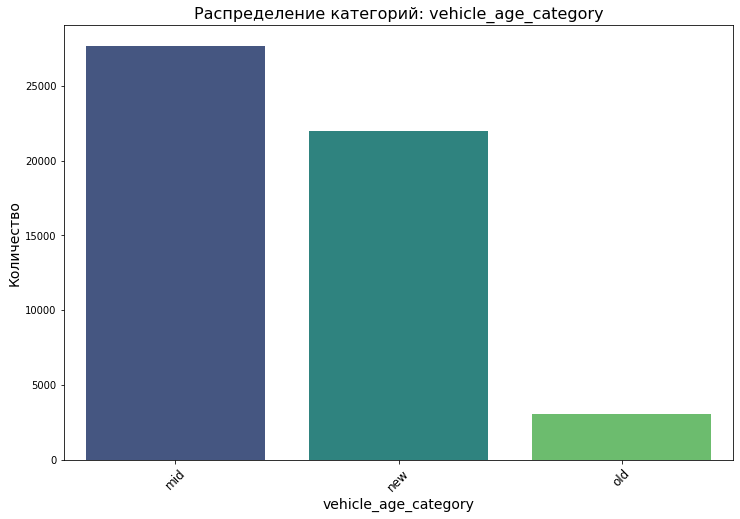

In [ ]:
plt.figure(figsize=(12, 8))
order = df_model_clean['vehicle_age_category'].value_counts().index
sns.countplot(x=df_model_clean['vehicle_age_category'], palette='viridis', order=order)
plt.title('Распределение категорий: vehicle_age_category', fontsize=16)
plt.xlabel('vehicle_age_category', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

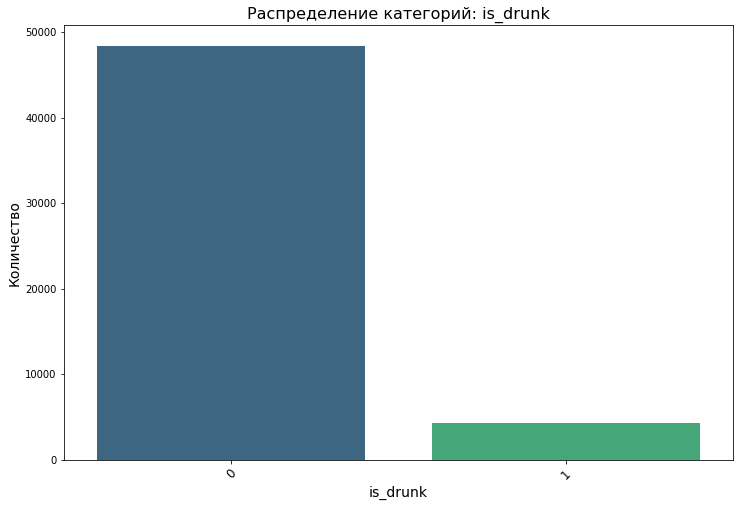

In [ ]:
plt.figure(figsize=(12, 8))
order = df_model_clean['is_drunk'].value_counts().index
sns.countplot(x=df_model_clean['is_drunk'], palette='viridis', order=order)
plt.title('Распределение категорий: is_drunk', fontsize=16)
plt.xlabel('is_drunk', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable case_id is large: 42224. Are you sure this is not an interval variable? Analysis for pairs of variables including case_id can be slow.
  warnings.warn(


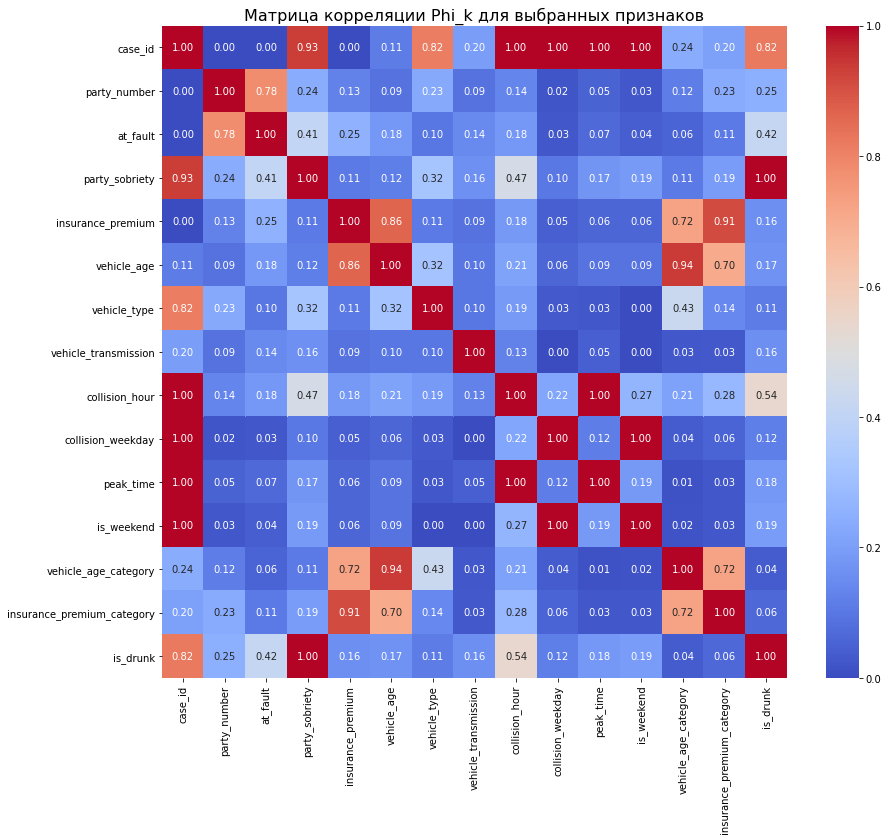

In [ ]:
# Определяем числовые столбцы для анализа, исключая 'case_id'
interval_cols = [col for col in numeric_columns + ['at_fault'] if col != 'case_id']

# Вычисление Phi_k матрицы для указанных столбцов
phi_k_matrix = df_model_clean.phik_matrix(interval_cols=interval_cols)

# Визуализация матрицы Phi_k
plt.figure(figsize=(14, 12))
sns.heatmap(phi_k_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляции Phi_k для выбранных признаков", fontsize=16)
plt.show()

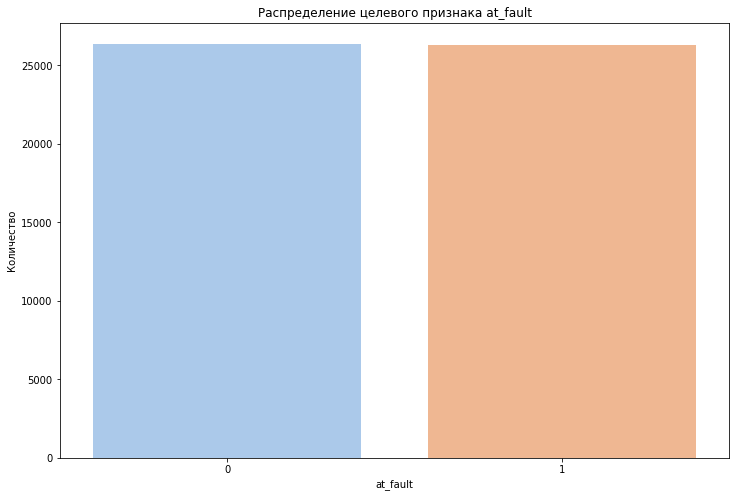

Распределение at_fault:


0    26383
1    26293
Name: at_fault, dtype: int64

In [ ]:
# Распределение целевого признака at_fault
plt.figure(figsize=(12, 8))
sns.countplot(x=df_model_clean['at_fault'], palette='pastel')
plt.title('Распределение целевого признака at_fault')
plt.xlabel('at_fault')
plt.ylabel('Количество')
plt.show()

# Вывод таблицы распределения
print("Распределение at_fault:")
display(df_model_clean['at_fault'].value_counts())

Выявленные распределения и взаимосвязи между признаками дают основания полагать, что выбранные признаки (как исходные, так и созданные в результате feature engineering) могут эффективно помочь в построении модели для оценки риска ДТП.
    

До feature engineering показатели моделей были в пределах 0.67

<div class="alert alert-info">

**Выбранная метрика: ROC-AUC**

**Обоснование:**
- **Баланс между чувствительностью и специфичностью:**  
  ROC-AUC (Area Under the Receiver Operating Characteristic Curve) позволяет оценивать, насколько хорошо модель различает классы, не завися от выбранного порогового значения. Это особенно важно, когда бизнес-задача связана с выявлением рискованных ситуаций, где необходимо минимизировать как ложноположительные, так и ложноотрицательные случаи.

- **Устойчивость к несбалансированности классов:**  
  Даже если классы в данных окажутся слегка несбалансированными, ROC-AUC остаётся стабильной и предоставляет объективную оценку качества модели.

- **Интегральная оценка модели:**  
  Поскольку ROC-кривая строится по всем возможным порогам, метрика даёт интегральное представление о способности модели различать случаи ДТП (виновные/невиновные), что важно для предупреждения потенциальных аварий.

Таким образом, ROC-AUC позволяет учитывать и полноту (recall), и специфичность (specificity), что делает её оптимальной для бизнес-задачи по оценке риска ДТП.
   
</div>

## Обучение моделей

In [ ]:
# Формирование обучающей выборки из очищенного датасета (df_model_clean)
X = df_model_clean[['party_sobriety', 'vehicle_type', 'vehicle_transmission',
                    'peak_time', 'is_weekend', 'is_drunk',
                    'insurance_premium', 'vehicle_age', 'collision_hour', 'collision_weekday']]
y = df_model_clean['at_fault']

print("Размер X:", X.shape)
print("Размер y:", y.shape)

# Разделение выборки на обучающую и тестовую (с сохранением пропорций целевого признака)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

Размер X: (52676, 10)
Размер y: (52676,)
X_train: (42140, 10) y_train: (42140,)
X_test : (10536, 10) y_test : (10536,)


In [ ]:
categorical = ['party_sobriety', 'vehicle_type', 'vehicle_transmission',
               'peak_time', 'is_weekend', 'is_drunk']

numeric = ['insurance_premium', 'vehicle_age', 'collision_hour', 'collision_weekday']


preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', sparse=False), categorical),
    ('scale', StandardScaler(), numeric)
])

In [ ]:
# Определение пайплайнов для различных моделей
pipelines = {
    'CatBoost': Pipeline([
        ('prep', preprocessor),
        ('clf', CatBoostClassifier(random_seed=42, verbose=False))
    ]),
    'LightGBM': Pipeline([
        ('prep', preprocessor),
        ('clf', LGBMClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ]),
    'LogisticRegression': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'DecisionTree': Pipeline([
        ('prep', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(random_state=42))
    ])
}

# Определение сеток гиперпараметров для каждой модели
param_grids = {
    'CatBoost': {
        'clf__iterations': [100, 200],
        'clf__learning_rate': [0.01, 0.1],
        'clf__depth': [4, 6]
    },
    'LightGBM': {
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.01, 0.1],
        'clf__num_leaves': [15, 31]
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.01, 0.1],
        'clf__max_depth': [4, 6]
    },
    'LogisticRegression': {
        'clf__C': [0.1, 1, 10]
    },
    'DecisionTree': {
        'clf__max_depth': [None, 5, 10, 15],
        'clf__min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 5, 10],
        'clf__min_samples_split': [2, 5]
    }
}

In [ ]:
results = []
best_models = {}

for name in pipelines:
    print(f"Запуск GridSearchCV для модели {name}...")
    gs = GridSearchCV(
        pipelines[name],
        param_grids[name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )

    with tqdm_joblib(tqdm(desc=f"GridSearchCV — {name}", total=len(param_grids[name])), leave=False):
        gs.fit(X_train, y_train)

    best = gs.best_estimator_
    best_models[name] = best  # Сохраняем лучший пайплайн для модели
    y_pred_proba = best.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_pred_proba)
    results.append((name, roc, gs.best_params_))

# Формируем итоговую таблицу результатов
df_comparison = pd.DataFrame(results, columns=['Model', 'ROC-AUC', 'Best_Params']) \
                   .sort_values('ROC-AUC', ascending=False)
print("Сравнение моделей:")
print(df_comparison)

Запуск GridSearchCV для модели CatBoost...


GridSearchCV — CatBoost:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.01; total time=   1.4s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.01; total time=   1.3s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.01; total time=   1.4s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.01; total time=   1.4s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.01; total time=   1.3s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.1; total time=   1.3s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.1; total time=   1.4s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.1; total time=   1.4s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.1; total time=   1.3s
[CV] END clf__depth=4, clf__iterations=100, clf__learning_rate=0.1; total time=   1.3s
[CV] END clf__depth=4, clf__iterations=200, clf__learning_rate=0.


GridSearchCV — LightGBM:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=15; total time=   1.4s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=15; total time=   1.9s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=15; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=15; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=15; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31; total time=   1.6s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31; total time=   1.6s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31; total time=   1.6s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31; total time=   2.0s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31;

GridSearchCV — CatBoost:   0%|          | 0/3 [01:39<?, ?it/s]


[CV] END clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=15; total time=   2.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=31; total time=   3.1s
[CV] END clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=31; total time=   3.1s
[CV] END clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=31; total time=   3.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=31; total time=   3.1s
[CV] END clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=31; total time=   3.3s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=15; total time=   1.3s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=15; total time=   1.0s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=15; total time=   1.1s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=15; total time=   1.1s
[CV] END clf__learning_rate=0.1, clf__n_esti

GridSearchCV — XGBoost:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=100; total time=   5.7s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=100; total time=   5.5s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=100; total time=   5.8s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=100; total time=   5.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=100; total time=  17.5s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=200; total time=  53.8s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=200; total time=  11.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=200; total time=  10.8s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=200; total time=  11.1s
[CV] END clf__learning_rate=0.01, clf__max_depth=4, clf__n_estimators=200; total time=  10.9s




GridSearchCV — LogisticRegression:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .........................................clf__C=0.1; total time=   2.1s
[CV] END .........................................clf__C=0.1; total time=   2.1s
[CV] END .........................................clf__C=0.1; total time=   2.7s
[CV] END .........................................clf__C=0.1; total time=   2.1s
[CV] END .........................................clf__C=0.1; total time=   3.2s
[CV] END ...........................................clf__C=1; total time=   3.5s
[CV] END ...........................................clf__C=1; total time=   2.5s
[CV] END ...........................................clf__C=1; total time=   2.8s
[CV] END ...........................................clf__C=1; total time=   2.4s
[CV] END ...........................................clf__C=1; total time=   4.3s
[CV] END ..........................................clf__C=10; total time=   5.9s
[CV] END ........................................




GridSearchCV — DecisionTree:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

GridSearchCV — LogisticRegression:   0%|          | 0/1 [00:49<?, ?it/s]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV] END ......clf__max_depth=None, clf__min_samples_split=2; total time=   0.3s
[CV] END ......clf__max_depth=None, clf__min_samples_split=2; total time=   0.2s
[CV] END ......clf__max_depth=None, clf__min_samples_split=2; total time=   0.2s
[CV] END ......clf__max_depth=None, clf__min_samples_split=2; total time=   0.2s
[CV] END ......clf__max_depth=None, clf__min_samples_split=2; total time=   0.2s
[CV] END ......clf__max_depth=None, clf__min_samples_split=5; total time=   0.2s
[CV] END ......clf__max_depth=None, clf__min_samples_split=5; total time=   0.2s
[CV] END ......clf__max_depth=None, clf__min_samples_split=5; total time=   0.2s


GridSearchCV — LightGBM:   0%|          | 0/3 [10:43<?, ?it/s]


[CV] END ......clf__max_depth=None, clf__min_samples_split=5; total time=   0.3s
[CV] END ......clf__max_depth=None, clf__min_samples_split=5; total time=   0.2s
[CV] END .....clf__max_depth=None, clf__min_samples_split=10; total time=   0.2s
[CV] END .....clf__max_depth=None, clf__min_samples_split=10; total time=   0.2s
[CV] END .....clf__max_depth=None, clf__min_samples_split=10; total time=   0.2s
[CV] END .....clf__max_depth=None, clf__min_samples_split=10; total time=   0.2s
[CV] END .....clf__max_depth=None, clf__min_samples_split=10; total time=   0.2s
[CV] END .........clf__max_depth=5, clf__min_samples_split=2; total time=   0.1s
[CV] END .........clf__max_depth=5, clf__min_samples_split=2; total time=   0.1s
[CV] END .........clf__max_depth=5, clf__min_samples_split=2; total time=   0.1s
[CV] END .........clf__max_depth=5, clf__min_samples_split=2; total time=   0.1s
[CV] END .........clf__max_depth=5, clf__min_samples_split=2; total time=   0.1s
[CV] END .........clf__max_d

GridSearchCV — RandomForest:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.8s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.7s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.7s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.8s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.7s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=   5.4s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=   5.3s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=   5.3s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=200; total time=   5.3s
[CV] END clf__max_depth=None, clf__min_samples_split=2, c

In [ ]:
# Определяем лучшую модель по максимальному значению ROC-AUC
best_row = df_comparison.iloc[0]
best_model_name = best_row['Model']
best_model = best_models[best_model_name]

print("Лучшая модель:", best_model_name)
print("Лучшие параметры:", best_row['Best_Params'])
print("ROC-AUC на тестовой выборке:", best_row['ROC-AUC'])

Лучшая модель: CatBoost
Лучшие параметры: {'clf__depth': 6, 'clf__iterations': 100, 'clf__learning_rate': 0.1}
ROC-AUC на тестовой выборке: 0.7074265929891324


<div class="alert alert-info">

**Аргументация выбора признаков:**

1. **party_sobriety (Уровень трезвости водителя):**  
   - **Почему важно:** Нетрезвость водителя существенно повышает риск ДТП. Это один из ключевых факторов, который напрямую влияет на безопасность на дороге.
   
2. **vehicle_age (Возраст автомобиля):**  
   - **Почему важно:** С возрастом автомобиля могут накапливаться износ и технические проблемы, что увеличивает вероятность аварийной ситуации. Более старые автомобили могут обладать устаревшими системами безопасности.

3. **insurance_premium (Страховой премиум):**  
   - **Почему важно:** Размер страховой премии часто отражает риск, связанный с автомобилем и его владельцем. Более высокий премиум может указывать на более высокий риск ДТП, связанный с техническим состоянием или стилем вождения.

4. **vehicle_type и vehicle_transmission (Тип автомобиля и тип КПП):**  
   - **Почему важно:** Разные типы кузова и системы управления могут иметь различные характеристики безопасности. Например, миниваны и седаны могут вести себя по-разному в аварийных ситуациях.

5. **collision_hour и collision_weekday (Время и день недели, когда произошло ДТП):**  
   - **Почему важно:** Время суток и день недели могут отражать особенности дорожного движения и пиковые часы, что также влияет на вероятность аварии. Эти признаки можно использовать для создания дополнительных индикаторов, например, "peak_time" или "is_weekend".

6. **Созданные признаки (feature engineering):**  
   - **peak_time:** Бинарный признак, указывающий, попадает ли время поездки в утренний или вечерний пик.  
   - **is_weekend:** Индикатор того, что день недели является выходным.  
   - **is_drunk:** Бинарный признак, отражающий, был ли водитель нетрезв (на основе данных о трезвости).

**Общий вывод:**

Выбранные признаки охватывают как характеристики водителя и автомобиля, так и временные аспекты, влияющие на риск ДТП. Такой набор признаков позволяет модели учитывать как техническое состояние автомобиля, так и поведение водителя и условия дорожного движения. Это обоснование даёт возможность построить модель, способную эффективно оценивать риск ДТП еще до начала поездки.
    
</div>

### Проверка лучшей модели в работе

Матрица ошибок:
[[3972 1305]
 [2375 2884]]

Отчет классификации:
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      5277
           1       0.69      0.55      0.61      5259

    accuracy                           0.65     10536
   macro avg       0.66      0.65      0.65     10536
weighted avg       0.66      0.65      0.65     10536



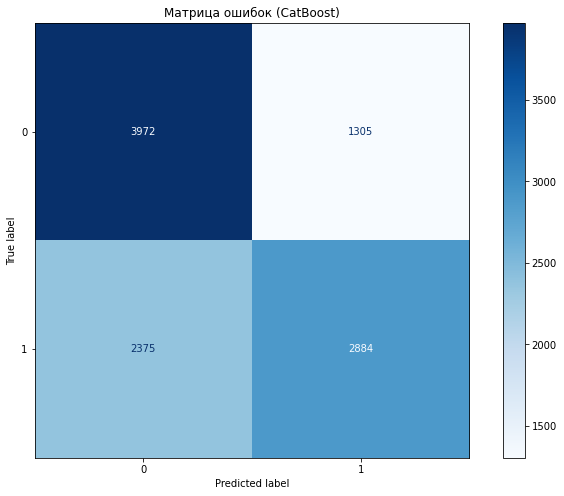

In [ ]:
# Предсказания лучшей модели
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Матрица ошибок и отчёт классификации
cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:")
print(cm)
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
fig, ax = plt.subplots(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues')
plt.title(f"Матрица ошибок ({best_model_name})")
plt.show()

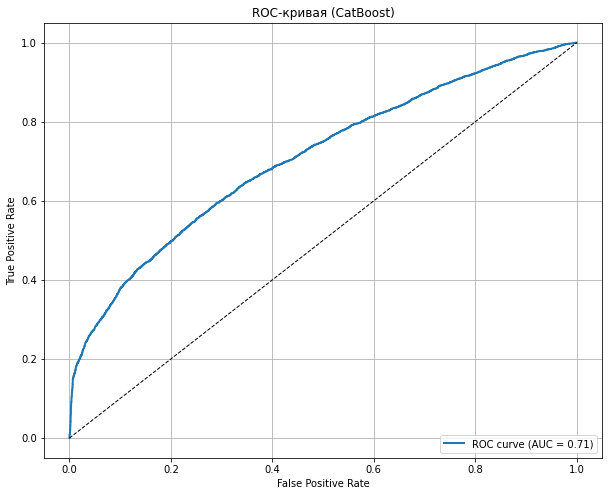

In [ ]:
# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая ({best_model_name})')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Проведите анализ важности факторов ДТП

Количество признаков в модели: 15
Размер вектора важностей: 15


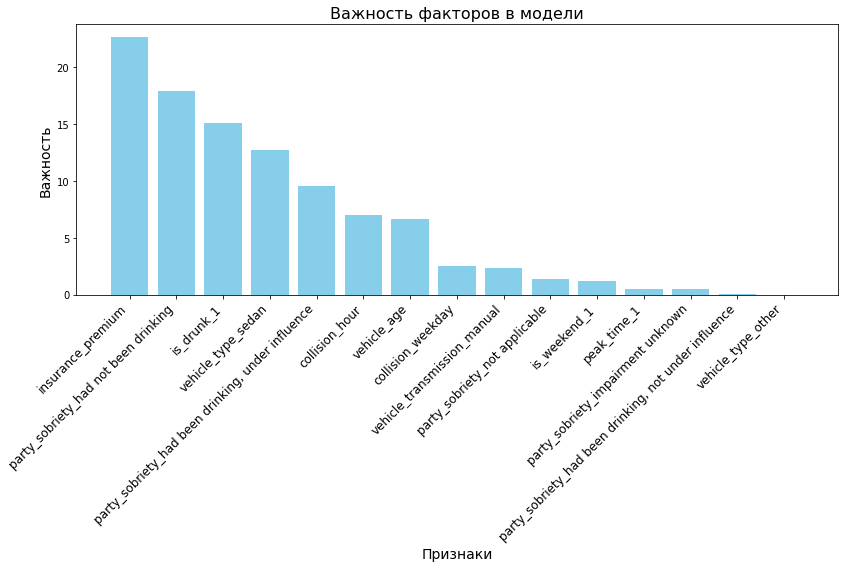

In [ ]:
# Извлекаем preprocessor и классификатор из лучшей модели
preprocessor = best_model.named_steps['prep']
clf = best_model.named_steps['clf']

# Определяем исходные признаки
categorical = ['party_sobriety', 'vehicle_type', 'vehicle_transmission', 'peak_time', 'is_weekend', 'is_drunk']
numeric = ['insurance_premium', 'vehicle_age', 'collision_hour', 'collision_weekday']

# Извлекаем имена категориальных признаков после OneHotEncoding
ohe = preprocessor.named_transformers_['ohe']
ohe_feature_names = list(ohe.get_feature_names(categorical))

# Итоговый список признаков
final_feature_names = ohe_feature_names + numeric

# Получаем важности признаков из модели:
if hasattr(clf, 'get_feature_importance'):
    feature_importances = clf.get_feature_importance()
elif hasattr(clf, 'feature_importances_'):
    feature_importances = clf.feature_importances_
else:
    raise AttributeError("Классификатор не поддерживает извлечение важности признаков.")

print("Количество признаков в модели:", len(final_feature_names))
print("Размер вектора важностей:", len(feature_importances))

# Сортируем признаки по убыванию важности
indices = np.argsort(feature_importances)[::-1]
sorted_features = [final_feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_importances)), sorted_importances, color='skyblue')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=45, ha='right', fontsize=12)
plt.xlabel("Признаки", fontsize=14)
plt.ylabel("Важность", fontsize=14)
plt.title("Важность факторов в модели", fontsize=16)
plt.tight_layout()
plt.show()

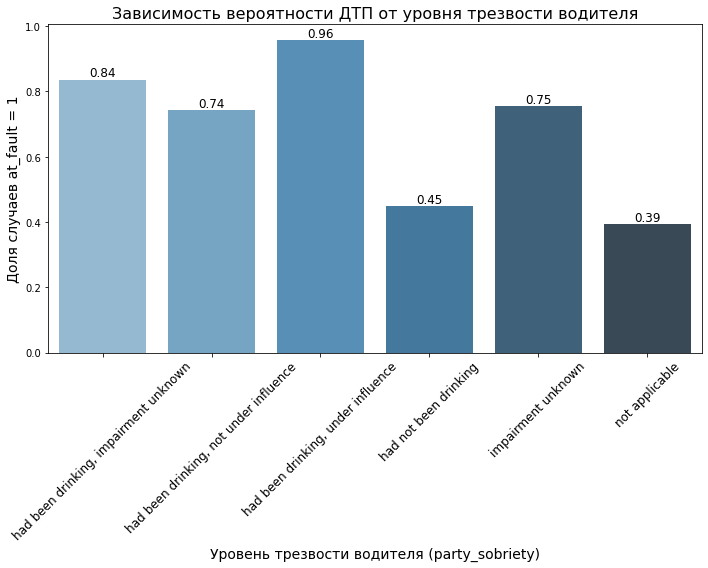

Результаты анализа уровня трезвости:


,party_sobriety,mean,count
0,"had been drinking, impairment unknown",0.836449,214
1,"had been drinking, not under influence",0.742754,552
2,"had been drinking, under influence",0.957481,4304
3,had not been drinking,0.448395,46575
4,impairment unknown,0.754926,812
5,not applicable,0.392694,219


In [ ]:
df_sobriety_analysis = df_model_clean.groupby('party_sobriety')['at_fault'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(data=df_sobriety_analysis, x='party_sobriety', y='mean', palette='Blues_d')
plt.xlabel("Уровень трезвости водителя (party_sobriety)", fontsize=14)
plt.ylabel("Доля случаев at_fault = 1", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.title("Зависимость вероятности ДТП от уровня трезвости водителя", fontsize=16)
for idx, row in df_sobriety_analysis.iterrows():
    plt.text(idx, row['mean'] + 0.01, f"{row['mean']:.2f}", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

print("Результаты анализа уровня трезвости:")
display(df_sobriety_analysis)

## Выводы

1. **Лучшая модель:**  
   - Наиболее высокую метрику ROC-AUC (≈ 0.71) показала модель **CatBoost** с параметрами `depth=6, iterations=100, learning_rate=0.1`.  
   - По итогам тестирования Accuracy составила ~0.65. Матрица ошибок и отчёт классификации свидетельствуют о том, что модель лучше предсказывает класс «не виновен» (0), чем «виновен» (1). Recall для «виновен» (1) — 0.55, Precision — 0.69.

2. **Анализ важности факторов:**  
   - Самым весомым фактором оказался **insurance_premium** (страховой взнос), затем — различные категории признака **party_sobriety** (уровень трезвости) и **vehicle_age** (возраст автомобиля).  
   - Это говорит о том, что финансовая оценка риска (премиум), состояние водителя и износ автомобиля — ключевые факторы, влияющие на вероятность ДТП.

3. **Уровень трезвости водителя:**  
   - Дополнительное исследование показало, что у водителей категории «had been drinking, under influence» доля `at_fault=1` достигает **96%**. У трезвых водителей («had not been drinking») — около 45%.  
   - Таким образом, нетрезвые водители в несколько раз чаще оказываются виновниками ДТП, что подтверждает высокую важность контроля трезвости.

4. **Выводы и рекомендации:**
   - Модель демонстрирует ROC-AUC ~0.71, что выше случайного угадывания, однако может потребовать расширения набора признаков для более точных прогнозов (например, учёт погоды, маршрута, стиля вождения).  
   - **Технические меры:** установка алкотестера в автомобиль, а также камеры для верификации личности водителя.  
   - **Сбор дополнительных данных:** штрафы, стаж вождения, телеметрия (скорость, резкие торможения), погодные условия и характеристики маршрута.

5. **Перспективы использования:**
   - Данная модель может служить основой для системы оценки риска при выдаче автомобиля каршеринга.  
   - При наличии дополнительных данных и доработке модели можно повысить точность и полноту выявления потенциально опасных ситуаций.
   
Проект показал, что создание системы оценки риска ДТП возможно, но требует сбора более богатых данных и учёта множества факторов. Тем не менее, уже на данном этапе модель демонстрирует разумный уровень ROC-AUC (около 0.71), а анализ важности факторов подчёркивает важность контроля трезвости водителя и технического состояния автомобиля.